# <center> Линейная алгебра в контексте линейных методов. Практика.

## <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [1]:
# Импорт библиотек
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame 
import seaborn as sns # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt # для построения графиков

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import cross_validate

from colorama import Fore, Back, Style

import optuna

# добавим пикселей для графиков, чтобы не так мыльно и уныло смотрелись
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

%matplotlib inline

In [2]:

# Определяем константы
RANDOM_STATE = 42
HYPER = 'Гиперпараметры'

LINREG = 'LinearRegression'
LINREGPOLY = 'LinearRegression PolyFeatures'
LINLASSO = 'LinearRegression Lasso'
LINRIDGE = 'LinearRegression Ridge'
LINELASTIC = 'LinearRegression Elastic'

In [3]:
# Создаем словарь для хранения результатов работ моделей
results = dict()

Прочитаем исходные данные:

In [4]:
data = pd.read_csv('data/unconv.csv')
data.head(3)

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574


## Линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.


### Задание 5.0. (не оценивается)

Проведите небольшой разведывательный анализ, чтобы поближе познакомиться с исходными данными. Постройте несколько визуализаций, которые помогут вам понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов. 

Сделайте промежуточные выводы из проведённого разведывательного анализа.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Well     200 non-null    int64  
 1   Por      200 non-null    float64
 2   Perm     200 non-null    float64
 3   AI       200 non-null    float64
 4   Brittle  200 non-null    float64
 5   TOC      200 non-null    float64
 6   VR       200 non-null    float64
 7   Prod     200 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 12.6 KB


1. В датасете представлено 200 строк, каждая из которых характеризуется 8 признаками
2. Значения представлены типами данных: 
  * целое
  * с плавающей точкой
3. Пропусков в данных нету  
4. Данные не стандартизированы
5. Данные не масштабированы



In [6]:
data.describe()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,14.991150,4.330750,2.968850,48.161950,0.990450,1.964300,4311.219852
std,57.879185,2.971176,1.731014,0.566885,14.129455,0.481588,0.300827,992.038414
min,1.000000,6.550000,1.130000,1.280000,10.940000,-0.190000,0.930000,2107.139414
25%,50.750000,12.912500,3.122500,2.547500,37.755000,0.617500,1.770000,3618.064513
50%,100.500000,15.070000,4.035000,2.955000,49.510000,1.030000,1.960000,4284.687348
75%,150.250000,17.402500,5.287500,3.345000,58.262500,1.350000,2.142500,5086.089761
max,200.000000,23.550000,9.870000,4.630000,84.330000,2.180000,2.870000,6662.622385


### Задание 5.1.

Постройте корреляционную матрицу факторов, включив в неё целевой признак. 

Для наглядности визуализируйте полученную матрицу с помощью тепловой карты. 

**Примечание.** *Для визуализации вы можете использовать любую из знакомых вам библиотек.*

На основе построенной корреляционной матрицы ответьте на следующий вопрос:

* Какие факторы сильнее всего коррелируют с целевой переменной?

Вычислите ранг и определитель полученной матрицы корреляций и приведите развёрнутые ответы на следующие вопросы:
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для расчёта корреляционной матрицы;
    * приведён код для визуализации корреляционной матрицы в виде тепловой карты;
    * рассчитаны ранг и определитель корреляционной матрицы;
    * предоставлены обоснованные ответы на все поставленные вопросы. 

- Задание выполнено верно, но не учтено одно условие (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [7]:
# Строим корреляционную матрицу зависимости факторов
data_corr = data.corr()

# Задаем стиль для отображения таблицы вывода
def make_pretty(styler,title):
    styler.set_caption(title)
    styler.format(lambda x: f'{x:.2f}')
    styler.background_gradient(axis=None, vmin=0, vmax=1, cmap="YlGnBu")
    return styler
  
data_corr.style.pipe(make_pretty,"Корреляционная матрица")

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
Well,1.00,0.07,0.08,0.04,-0.08,0.02,-0.01,0.03
Por,0.07,1.00,0.76,-0.46,-0.22,0.71,0.11,0.86
Perm,0.08,0.76,1.00,-0.24,-0.12,0.47,0.05,0.73
AI,0.04,-0.46,-0.24,1.00,0.13,-0.53,0.50,-0.39
Brittle,-0.08,-0.22,-0.12,0.13,1.00,-0.21,0.32,0.24
TOC,0.02,0.71,0.47,-0.53,-0.21,1.00,0.30,0.65
VR,-0.01,0.11,0.05,0.50,0.32,0.30,1.00,0.32
Prod,0.03,0.86,0.73,-0.39,0.24,0.65,0.32,1.00


In [8]:
# ТОП 3 признака имеющих самую высокую корреляцию с целевым признаком Prod
data_corr.abs().round(2).Prod.\
  sort_values(ascending=False).head(4)[1:].to_frame().\
  style.pipe(make_pretty,'Топ 3 сколлерированных фактора')

,Prod
Por,0.86
Perm,0.73
TOC,0.65


In [9]:
# Ранк матрицы
print(f'{Fore.LIGHTBLUE_EX}{"Ранк матрицы:":.<30s}{Back.RESET}{Fore.LIGHTGREEN_EX}{np.linalg.matrix_rank(data_corr):.>6d}')

Ранк матрицы:......................8


In [10]:
# Детерминант матрицы
print(f'{Fore.LIGHTBLUE_EX}{"Детерминант матрицы:":.<30s}{Back.RESET}{Fore.LIGHTGREEN_EX}{np.linalg.det(data_corr):.>6.4f}')

Детерминант матрицы:..........0.0007


Текущая матрица близка к вырожденной, так как значение ее детерминанта достаточно мало. Соответственно данные являются плохо обусловленными. Как результат, хорошего решения классическим способом линеной регрессии, мы получить не сможем.

Также мы имеем корелляцию между признаками и присутствует мультиколлинеарность.

Я считаю, что применять в данном случае модель по методу наименьших квадратов - некорректно. Прогнозы на различных данных могут сильно ошибаться, при чем в разные стороны. Такжее качество прогноза будет сильно варьировать при добавлении новых данных.

### Задание 5.2.

Создайте матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмите все имеющиеся в данных признаки. 

Постройте модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК и инструментарием библиотеки numpy. 

Выведите на экран полученные оценки коэффициентов модели, округлённые до целого.

Приведите подробные выводы по полученным результатам, ответив на следующие вопросы:
* Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
* Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для нахождения параметров модели линейной регрессии с помощью матричной формулы МНК;
    * на основе полученных параметров даны верные ответы на поставленные вопросы;
    * приведена корректная интерпретация нескольких коэффициентов полученной модели линейной регрессии.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [11]:
# Создаем матрицу наблюдений X и вектор целевой переменной
X = np.column_stack((np.ones(data.shape[0]), data.iloc[:,:7].values))
y = data.Prod

# вычислим OLS-оценку для коэффициентов
w_coeff = np.linalg.inv(X.T@X)@X.T@y

w_coeff_df = pd.DataFrame(data=w_coeff
                          ,index=np.hstack((['Intercept'],np.array(data.columns[:-1]))),
                          columns = ['Коэффициент'])
mean_data = pd.concat([pd.Series( data=[0], index = ['Intercept']),\
  data.describe().loc['mean',:][:-1]])

w_coeff_df = pd.concat([w_coeff_df, mean_data], axis = 1).rename(columns = {0: 'Cр. значение'})
w_coeff_df['Дельта'] = w_coeff_df.iloc[:,0] * w_coeff_df.iloc[:,1]
w_coeff_df_sorted = w_coeff_df.sort_values(by = ['Дельта'], ascending=False, key = abs)
w_coeff_df_sorted['Процент от макс'] = w_coeff_df_sorted.loc[:,'Дельта'] / w_coeff_df_sorted.loc[:,'Дельта'].max() * 100

w_coeff_df_sorted.style.format({'Коэффициент':'{:.0f}', 'Cр. значение':'{:.2f}', 'Дельта':'{:.2f}', 'Процент от макс':'{:.2f}' })

,Коэффициент,Cр. значение,Дельта,Процент от макс
Por,230,14.99,3450.65,100.00
VR,785,1.96,1542.49,44.70
Brittle,25,48.16,1203.78,34.89
AI,-365,2.97,-1084.23,-31.42
Perm,116,4.33,503.40,14.59
TOC,-78,0.99,-77.65,-2.25
Well,0,100.50,5.10,0.15
Intercept,-1232,0.00,-0.00,-0.00


Как мы видим, коэффициент отвечающий за идентификатор скважины - Well,
практически никак не влияет на вычисление, т.е очень минимально, по сравнению с другими признаками.
Также, мы имеем коэфициенты как с положительными, так и с отрицательными значениями.
Например в случае увеличения значения AI - мы получим прогноз уменьшения выработки в скважине.

Также я расчитал признак дельта, который расчитывается, как средняя величина признака умноженная на коэффициент.
Это сделано для понимания, насколько каждый из признаков влияет на целевой признак

Как видно, больше всего влияет признак Por в сторону увеличения и признак AI в сторону уменьшения.

Также я применил сортировку по Дельта, и отсортировал по влиянию признака на целевую переменную от значимости к уменьшению.
Дополнительно ввел признак "Процент от макс", где максималная дельта была принята за 100% и расчет влияния других признаков был расчитан в процентах отношения к этому максимуму

Well, TOC, Perm оказывают меньше всего влияния, по сравнению с другими признаками. И это также видно в процентном соотношении

### Задание 5.3.

Теперь потренируемся строить предсказание для наблюдений целевой переменной. 

**а)** Постройте прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитайте абсолютную ошибку построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 

**б)** Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Выберите метрику, по которой вы будете оценивать качество регрессионных моделей и сравнивать их между собой (можно использовать несколько метрик, но не более двух).

Рассчитайте значение выбранной метрики для вашей модели. Приведите интерпретацию полученного результата. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для построения прогноза выработки газа на указанной скважине и рассчитана абсолютная ошибка прогноза для этой скважины;
    * выбрана корректная для поставленной задачи метрика (или метрики) оценки качества модели и приведён код для расчёта этой метрики на всём обучающем наборе данных;
    * приведена корректная интерпретация полученного результата.

- Задание выполнено верно, но не учтено одно из условий, или задание выполнено неверно (**0 баллов**).

In [12]:
# Сделаем прогноз для 106 скважины
# ее данные находятся под индексом 105 соответственно
new=np.hstack(([1],data.iloc[105].values[:-1]))
print(f'{Fore.LIGHTBLUE_EX}{"Предсказание по 106 скважине:":.<30s}{Back.RESET}{Fore.LIGHTGREEN_EX}{(new@w_coeff):.>12.0f}')

print(f'{Fore.LIGHTBLUE_EX}{"Метрика MAE на 106 скважине:":.<30s}{Back.RESET}{Fore.LIGHTGREEN_EX}{mean_absolute_error([data.iloc[105,-1]],[new@w_coeff]):.>12.0f}')

# Сделаем предсказание на всем датасете
predict_df = (X@w_coeff)

print(f'{Fore.LIGHTBLUE_EX}{"Метрика MAPE на все скважины:":.<30s}{Back.RESET}{Fore.LIGHTGREEN_EX}{mean_absolute_percentage_error(y,predict_df)*100:.>11.2f}%')

Предсказание по 106 скважине:.........4723
Метрика MAE на 106 скважине:............25
Метрика MAPE на все скважины:........3.63%


На данном этапе мы видим, что MAPE очень низкий, что говорит о том, что мы имеем всего лишь 3.6% ошибку, что по мне является очень хорошим показателем. Опять же, в условиях заказанного прогноза, у нас нет никаких пожеланий относительно значений метрик. Поэтому в данный момент может принять, что модель справляется неплохо, и продолжить исследование дальше 

Опять же, возможно, что предоставленные параметры, в глобальном случае всегда будут иметь такие же диапазоны параметров, и тогда собранная нами модель будет очень неплохо предсказывать.
Однако, надо относится к этому с большой долей скепцизма и помнить, что модель собранная на плохо обусловленных данных, может такой и оказаться на самом деле, при появлении новых диапазонов или сочетаний для текущих признаков, и сраз "уехать" совсем в другие горизонты

### Задание 5.4.

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.

Дайте развёрнутые ответы на следующие вопросы:

* Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целевой переменной прямая, а модель говорит обратное. Если таких факторов несколько, укажите их все.
* Как вы считаете, с чем связано полученное противоречие результатов?

**Критерии оценивания:**

- Задание выполнено верно, даны корректные развёрнутые ответы на все поставленные в задании вопросы (**1 балл**). 

- Задание выполнено неверно, даны некорректные ответы на один или несколько поставленных в задании вопросов (**0 баллов**).

In [14]:

def highlight_rows(row):
    """Функция проверяет если Коррэляционный коэффициент имеет различный знак с Коэффициентом

    Args:
        row (Series): Строка

    Returns:
        _type_: Возвращает форматирование для background
    """
    if ((row[0] < 0) & (row[1] > 0)) | ((row[0] > 0) & (row[1] < 0)):
        color = '#8b21b1'
    else:
        color = '000'
    return ['background-color: {}'.format(color) for r in row]

In [15]:
# Проанализируем построенную модель
res_df_styled = pd.concat([data_corr.round(2).Prod[:-1], w_coeff_df.iloc[:,0]], axis = 1).\
  rename(columns={'Prod':'Кор. коэф'}).style.format({'Кор. коэф':'{:.2f}','Коэффициент':'{:.2f}'})\
    .apply(highlight_rows, axis=1)
res_df_styled    

,Кор. коэф,Коэффициент
Well,0.03,0.05
Por,0.86,230.18
Perm,0.73,116.24
AI,-0.39,-365.20
Brittle,0.24,24.99
TOC,0.65,-78.40
VR,0.32,785.26
Intercept,nan,-1232.31


 Если мы внимательно посмотрим, то увидим разницу в знаке в коэффициенте и кореляции с целевым признаком у признака Toc. Т.е векторы Toc и Prod сонаправлены, исходя из положительного коэффициента корелляции между этими признаками, однако если же мы посмотрим на коэффициент, то заметим что он идет со знаком "-". И это некорректно, так как прогнозируемая величина будет падать, в случае возрастания значения данного признака, что неправильно. И модель будет давать все большую ошибку.
 Это может быть обусловлено наличием сильной мультиколлинеарности в данных, которая «портит» коэффициенты. 

 Чтобы убедится в правоте наших выводов, посторим график зависости признака Toc от целевой переменной Prod. Как мы видим на графике, зависимость между признаками прямая и линейная, т.е с ростом одного признака, растет и другой.

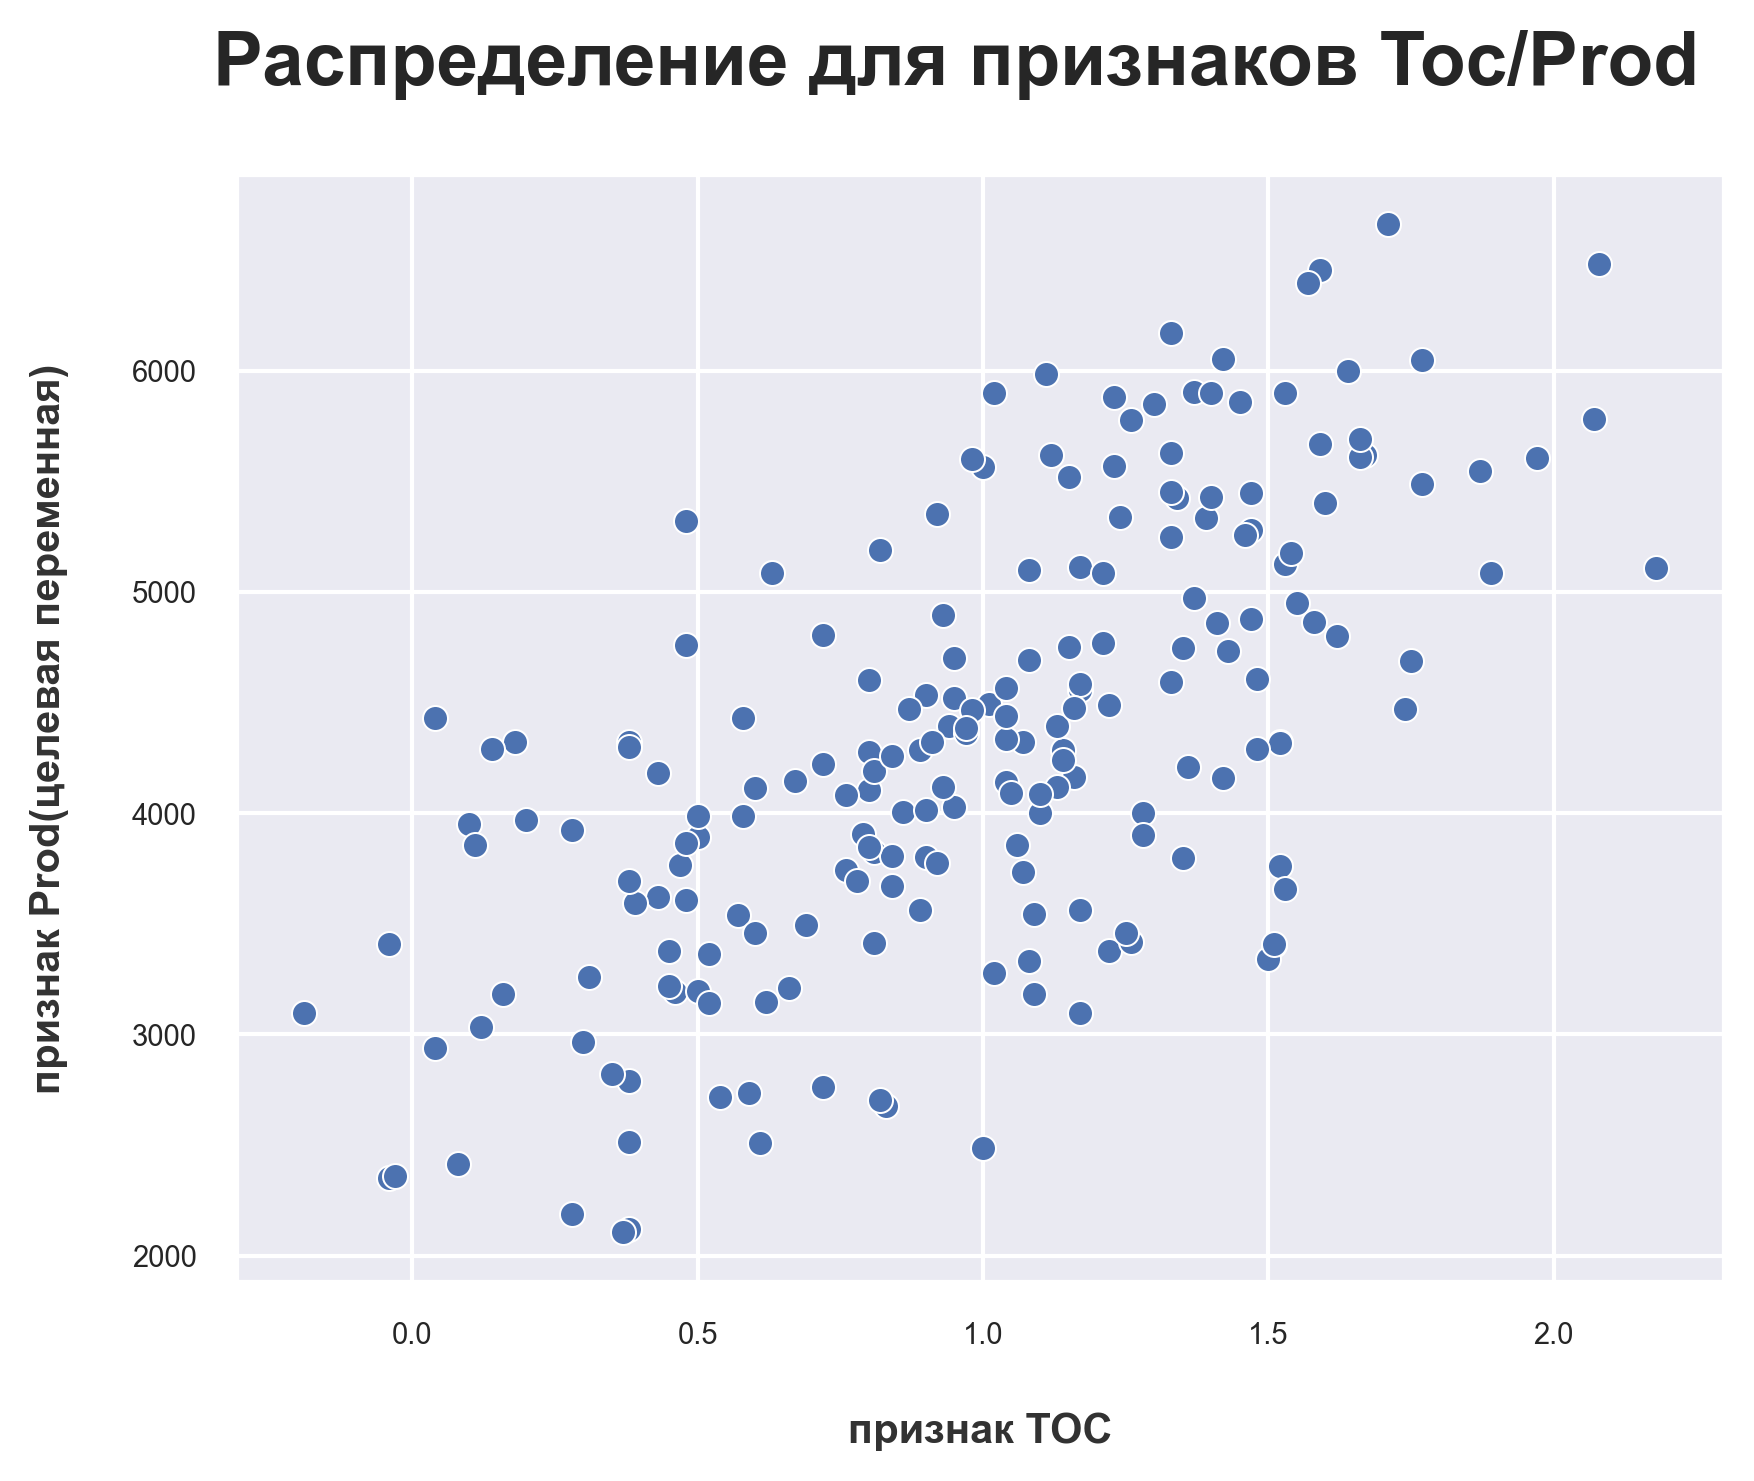

In [16]:
ax = sns.scatterplot(x='TOC', y='Prod', data=data)

#modify individual font size of elements
plt.suptitle('Распределение для признаков Toc/Prod', size = 18, weight = 600)
ax.set_xlabel('признак TOC', fontsize=10, labelpad = 15,
           fontdict = {'color' : '#323232', 'fontweight' : 600})
ax.set_ylabel('признак Prod(целевая переменная)', fontsize=10, labelpad = 15,
           fontdict = {'color' : '#323232', 'fontweight' : 600})
ax.tick_params(axis='both', which='major', labelsize=7)

### Задание 5.5.

* Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`.

Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).

* Также исключите из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте матричную формулу и библиотеку numpy. Выведите значение полученных коэффициентов, округлённых до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте выбранную вами ранее метрику (или метрики). 

Дайте подробные ответы на следующие вопросы:

* Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
* Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее. 
* Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * отобраны верные факторы;
    * на основе отобранных факторов построена модель линейной регрессии с помощью матричной формулы МНК и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * даны ответы на все поставленные в задании вопросы.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено верно, не учтено несколько из условий (**0 баллов**).

In [17]:
# Получим признаки, которые имеют кореляцию между собой больше 0.7
mask = np.triu(np.ones_like(data_corr, dtype=bool))

# путем нехитрых преобразований, получим таблицу только с требуемыми в заданиями значениями корреляции между признаками
data_corr_masked = data_corr[mask].unstack().drop_duplicates().reset_index()[1:].\
  sort_values(by = 0, ascending=False, key=abs).\
  rename(columns={0:'Корреляция'})
data_corr_masked_final = data_corr_masked[abs(data_corr_masked['Корреляция'])>.7].\
  query("level_1 != 'Prod'")
display(data_corr_masked_final)

# Выделим названия этих признаков
corr_features = list(set(data_corr_masked_final.iloc[:,:2].stack().values))

# закинем список из корелируемых признаков и получим для них значение их корелеляций с целевым признаком
pd.DataFrame(data = [data_corr.loc['Prod',corr_features[idx]].round(2) for idx, feature in enumerate(corr_features)],
             columns=['Коэф Кореляции с целевым признаком'],
             index = corr_features).sort_values(by ='Коэф Кореляции с целевым признаком',ascending=False)

,level_0,level_1,Корреляция
8,Por,Perm,0.760546
11,Por,TOC,0.711831


,Коэф Кореляции с целевым признаком
Por,0.86
Perm,0.73
TOC,0.65


Удалим признаки, где корреляция между собой выше 0.7 и ниже 0.05
Но при этом оставим признак, который максимально корелирует с добычей 
Удаляем признаки Perm, Toc и Well, соответственно
Por, как самый корелируемый с добычей - остается

In [18]:
# Создаем матрицу наблюдений X и вектор целевой переменной, но уже с удаленными признаками
X_new = np.column_stack((np.ones(data.shape[0]), pd.concat([data.iloc[:,1:2],data.iloc[:,3:5],data.iloc[:,6]], axis = 1).values))
y = data.Prod


# вычислим OLS-оценку для коэффициентов
w_coeff_new = np.linalg.inv(X_new.T@X_new)@X_new.T@y

w_coeff_df_new = pd.DataFrame(data=w_coeff_new
                          ,index=np.hstack((['Intercept'],np.hstack([data.columns[1],data.columns[3:5],data.columns[6]]))),
                          columns = ['Коэффициент'])
# Получение коэффициентов модели на новом наборе признаков
display(w_coeff_df_new.round())

# предсказание на всем датасете с новыми коэффициентами
predict_df_new = (X_new@w_coeff_new)

print(f'{Fore.LIGHTBLUE_EX}Метрика MAPE на все скважины:{Back.RESET}{Fore.LIGHTGREEN_EX}{mean_absolute_percentage_error(y,predict_df_new)*100:.>12.2f}')

# Проанализируем построенную модель на новых признаках
pd.concat([data_corr.round(2).Prod[[1,3,4,6]], w_coeff_df_new[1:]], axis = 1).\
  rename(columns={'Prod':'Кор. коэф'})

,Коэффициент
Intercept,-1835.0
Por,293.0
AI,-200.0
Brittle,28.0
VR,517.0


Метрика MAPE на все скважины:........4.04


,Кор. коэф,Коэффициент
Por,0.86,293.036246
AI,-0.39,-200.030912
Brittle,0.24,27.640982
VR,0.32,517.402726


* Как мы видим, удаление скореллированных признаков помогло нам избавится от некорректного поведения модели, когда при увеличении значения мы получали уменьшение целевого параметра, при ожидаемом увеличении (смотрите в выводах выше)
* Так-же немного ухушилась метрика, но все равно осталась тоже в очень хорошем диапазоне.
* Также изменились коэффициенты, по сравнению с моделью, обученной на всех признаках

В дополнении давайте расчитаем определитель матрицы с новыми, укороченными признаками.

Как мы видим(результат ниже), детерминант увеличился, что говорит об улучшении модели в сторону "устойчивости" корректности прогнозирования результата



In [19]:
print(f'{Fore.LIGHTBLUE_EX}Детерминант матрицы:{Back.RESET}{Fore.LIGHTGREEN_EX}{np.linalg.det(np.corrcoef(X_new[:,1:], rowvar=False)):.>12.4f}')

Детерминант матрицы:......0.3683


In [20]:
def modelRun_Print_Save_Results(model, data, y, modelName, cv = 5, polyFeatures = 'Нет'):
  """Функция расчитывает метрики по кроссвалидному обучению, выводит их на экран и заносит эти данные в словарь results

  Args:
      model (sklearn model): Обученная модель из библиотеки sklearn
      data (np.array): Данные для обучения
      y (np.array): вектор с целевой переменной
      modelName (str): название модели
      cv (int, optional): Количество кросс фолдов. Defaults to 5.
  """
  # оцениваем качество модели на кросс-валидации, метрика — MAPE
  cv_results = cross_validate(model, data, y, scoring='neg_mean_absolute_percentage_error', cv = cv, return_train_score=True)
  res_train = -cv_results["train_score"].mean()* 100
  res_test = -cv_results["test_score"].mean()* 100
  
  #вывод на экран 
  print(f'{Fore.LIGHTBLUE_EX}{"Метрика MAPE на тренировочных фолдах:":.<60s}{Back.RESET}{Fore.LIGHTGREEN_EX}{res_train:.>12.2f}%')
  print(f'{Fore.LIGHTBLUE_EX}{"Метрика MAPE на тестовых фолдах:":.<60s}{Back.RESET}{Fore.LIGHTGREEN_EX}{res_test:.>12.2f}%')
  # запись результатов
  results[modelName] = {'MAPE TRAIN':res_train,'MAPE TEST': res_test, 'PolyFeatures': polyFeatures}
  

### Задание 5.6.

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную. 

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуйтесь классом `LinearRegression` из библиотеки `sklearn`. Выведите значения полученных коэффициентов, округлённые до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте значение выбранной вами метрики (или метрик).

Сравните результаты библиотечной реализации с тем, что вы получили ранее. 

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов построена модель линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * приведён вывод о соответствии результатов, полученных вручную и с помощью библиотеки.
- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [21]:
# создаём модель линейной регрессии
model = LinearRegression(fit_intercept=False)

# вычисляем коэффициенты регрессии
model.fit(X_new, y)

w_coeff_df_lr = pd.DataFrame(data=model.coef_
                          ,index=np.hstack((['Intercept'],np.hstack([data.columns[1],data.columns[3:5],data.columns[6]]))),
                          columns = ['Коэффициент'])
display(w_coeff_df_lr.round())

# сделаем предсказание
predict_df_new_lr = model.predict(X_new)

print(f'{Fore.LIGHTBLUE_EX}Метрика MAPE на все скважины:{Back.RESET}{Fore.LIGHTGREEN_EX}{mean_absolute_percentage_error(y,predict_df_new)*100:.>12.2f}')

,Коэффициент
Intercept,-1835.0
Por,293.0
AI,-200.0
Brittle,28.0
VR,517.0


Метрика MAPE на все скважины:........4.04


In [22]:
# В задании не указано расчитать MAPE на тренировочном и тестовом наборе, но я сделаю это дополнительно, чтобы позже сравнить с результатами других моделей

modelRun_Print_Save_Results(model, X_new, y, modelName=LINREG, cv=5, polyFeatures='Нет')

results[LINREG][HYPER] = 'подборка гиперпараметров не проводилась'


Метрика MAPE на тренировочных фолдах:...............................4.02%
Метрика MAPE на тестовых фолдах:....................................4.23%


Как мы видим, как минимум, округленные коэффициенты, полученные в результате обучения модели LinearRegression из библиотеки Scikit-learn, полностью идентичны значениям коэффициентов, полученных нами путем путем применения матричной формулы NumPy.

Тоже само можно отметить и про метрику, что было ожидаемо.
Т.е алгоритмы scikit LinearRegression построены на тех же правилах, что и матричный метод наименьшиъх квадратов.

## Практика: полиномиальная регрессия и регуляризация

Мы продолжаем работать над задачей от владельца компании «Газ-Таз-Ваз-Нефть» Василия.

Ранее мы построили модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. **Далее мы будем использовать именно их (см. задание 5.5).**

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию. 

Приступим! Выполните задания 8.1–8.5:


### Задание 8.1.

Стандартизируйте признаки с помощью `StandartScaler` из библиотеки `sklearn`. 

Затем сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` установите в значение `False`.

Выведите на экран, сколько факторов у вас получилось после генерации полиномиальных признаков.

**Важно:** стандартизацию необходимо произвести до генерации полиномиальных факторов!

Обучите модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов сгенерированы полиномиальные признаки третьего порядка;
    * построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).
- Задание выполнено неверно, не учтено одно или несколько из условий (**0 баллов**).

In [23]:
# инициализируем стандартизатор StandardScaler
scaler = StandardScaler()
# подгоняем параметры стандартизатора на данных из пункта 5.5 без единичного столца
X_poly = scaler.fit_transform(X_new[:,1:])
# добавляем полиномиальные признаки
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly_transformed = poly.fit_transform(X_poly)

print(f'{Fore.LIGHTBLUE_EX}{"Количество факторов после генерации полиномиальных признаков":60s}:{Back.RESET}{Fore.LIGHTGREEN_EX}{X_poly_transformed.shape[1]:.>12d}')

# создаём модель линейной регрессии
lr = LinearRegression()
 
modelRun_Print_Save_Results(lr, X_poly_transformed, y, modelName=LINREGPOLY, cv=5, polyFeatures='Да')

results[LINREGPOLY][HYPER] = 'подборка гиперпараметров не проводилась'

Количество факторов после генерации полиномиальных признаков:..........34
Метрика MAPE на тренировочных фолдах:...............................1.77%
Метрика MAPE на тестовых фолдах:....................................2.68%


Как мы знаем, Линеная регрессия представляет собой прямую, проведенную через все наблюдения, каждая в своей плоскости, в случае наличия более чем одного признака, так, чтобы ошибка отклонения от среднего была минимальна.
Однако, применение полинома, позволяет нам отойти от прямой, и строить кривую, и как результат, отклонение о среднего становится меньше, что улучшает предсказание.

Построив линейную регрессию с применением полинома третьей степени, мы улучшили показатели прогноза почти вдвое.
Также, в отличии от линейной регрессии полиноа степени 1, которая не склона к перетреннированности, ввиду своей прямоты, мы применили кроссвалидацию по 5-ти фолдам, чтобы максимально уйти от перетреннированности модели

### Задание 8.2.

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Обучите модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Lasso), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [24]:
def optuna_optimize(trial, type):
  """Функция для подбора гиперпараметров.

  Args:
      trial (_type_): Встроенная передача массива гиперпараметров. Передавать не надо, встроенный механизм библиотеки
      type (_type_): Указание для какой модели проводить оптимизацию

  Returns:
      _type_: Возвращает score = (cv_result_train + cv_result_test) * mean_absolute_error([cv_result_train],[cv_result_test]) * 100 + (cv_result_train+cv_result_test) 
      на основании которого, оптимизатор приниает решение о качестве найденных параметров
  """
  
  if type == LINLASSO:
    alpha = trial.suggest_float('alpha', 1, 20, step = 1)
    max_iter = trial.suggest_int('max_iter', 5000, 40000)
    fit_intercept = trial.suggest_categorical('fit_intercept',[True,False])
    copy_X = trial.suggest_categorical('copy_X',[True,False])
    warm_start = trial.suggest_categorical('warm_start',[True,False])
    selection = trial.suggest_categorical('selection',['cyclic','random'])

      # создаем модель
    model = Lasso(alpha=alpha
                  ,max_iter=max_iter
                  ,fit_intercept = fit_intercept
                  ,copy_X = copy_X
                  ,warm_start = warm_start
                  ,selection =selection
                  ,random_state=42
                  )
  elif type==LINRIDGE:
    alpha = trial.suggest_float('alpha', 1, 20, step = 1)
    max_iter = trial.suggest_int('max_iter', 5000, 40000)
    fit_intercept = trial.suggest_categorical('fit_intercept',[True,False])
    copy_X = trial.suggest_categorical('copy_X',[True,False])
    solver = trial.suggest_categorical('solver', ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'])

      # создаем модель
    model = Ridge(alpha=alpha
                  ,max_iter=max_iter
                  ,fit_intercept = fit_intercept
                  ,copy_X = copy_X
                  ,solver = solver
                  ,random_state=42
                  )
  elif type==LINELASTIC:
    alpha = trial.suggest_float('alpha', 1, 20, step = 1)
    l1_ratio = trial.suggest_float('l1_ratio', 0, 1, step = .01)
    max_iter = trial.suggest_int('max_iter', 5000, 40000)
    fit_intercept = trial.suggest_categorical('fit_intercept',[True,False])
    copy_X = trial.suggest_categorical('copy_X',[True,False])
    warm_start = trial.suggest_categorical('warm_start',[True,False])
    selection = trial.suggest_categorical('selection',['cyclic','random'])

      # создаем модель
    model = ElasticNet(alpha=alpha
                  ,l1_ratio = l1_ratio     
                  ,max_iter=max_iter
                  ,fit_intercept = fit_intercept
                  ,copy_X = copy_X
                  ,warm_start = warm_start
                  ,selection =selection
                  ,random_state=42
                  )
    
  # обучаем модель
  cv_result = cross_validate(model, X_poly_transformed, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
  
  cv_result_train = cv_result['train_score'].mean()
  cv_result_test = cv_result['test_score'].mean()
  
  score = (cv_result_train + cv_result_test) * mean_absolute_error([cv_result_train],[cv_result_test]) * 100 + (cv_result_train+cv_result_test)

  return abs(score)

In [25]:
def optunaOptimizationProcess(model, n_trials = 100):
  """Функция для создания сессии оптимизации

  Args:
      model (_type_): Тип моедли, для которой проводить оптимизацию
      n_trials (int, optional): Количество поисков. Defaults to 100.

  Returns:
      _type_: Результат посика гиперпараметров
  """
  study = optuna.create_study(study_name=model, 
                                    direction="minimize",
                                    storage='sqlite:///ex.db',
                                    load_if_exists=True                                   
                                    )
  # ищем лучшую комбинацию гиперпараметров n_trials раз

  optuna_params = lambda trial: optuna_optimize(trial, type = model)

  study.optimize(optuna_params, n_trials=n_trials
                        , n_jobs=-1
                        )
  return study

In [26]:
study_Lasso = optunaOptimizationProcess(LINLASSO, n_trials=500)
print(f'{"f":=^200}')
print("Наилучшие значения гиперпараметров {}".format(study_Lasso.best_params))

# создаём модель линейной регрессии c L1(Lasso) регуляризацией
lasso = Lasso(**study_Lasso.best_params,random_state=RANDOM_STATE)
modelRun_Print_Save_Results(lasso, X_poly_transformed, y, modelName=LINLASSO, cv=5, polyFeatures='Да')

results[LINLASSO][HYPER] = str(study_Lasso.best_params)

[I 2023-05-06 15:50:10,369] Using an existing study with name 'LinearRegression Lasso' instead of creating a new one.
[I 2023-05-06 15:50:19,014] Trial 530 finished with value: 0.05909471153955707 and parameters: {'alpha': 6.0, 'max_iter': 38576, 'fit_intercept': True, 'copy_X': False, 'warm_start': False, 'selection': 'cyclic'}. Best is trial 66 with value: 0.05909471153955707.
[I 2023-05-06 15:50:19,154] Trial 503 finished with value: 0.05909471153955707 and parameters: {'alpha': 6.0, 'max_iter': 38292, 'fit_intercept': True, 'copy_X': False, 'warm_start': False, 'selection': 'cyclic'}. Best is trial 66 with value: 0.05909471153955707.
[I 2023-05-06 15:50:19,309] Trial 531 finished with value: 0.05909471153955707 and parameters: {'alpha': 6.0, 'max_iter': 21732, 'fit_intercept': True, 'copy_X': False, 'warm_start': False, 'selection': 'cyclic'}. Best is trial 66 with value: 0.05909471153955707.
[I 2023-05-06 15:50:19,370] Trial 538 finished with value: 0.05909471153955707 and paramet

===================================================================================================f====================================================================================================
Наилучшие значения гиперпараметров {'alpha': 6.0, 'copy_X': False, 'fit_intercept': True, 'max_iter': 14450, 'selection': 'cyclic', 'warm_start': False}
Метрика MAPE на тренировочных фолдах:...............................1.85%
Метрика MAPE на тестовых фолдах:....................................2.28%


Была построена модель линейной регрессией с регуляризацией L1-Lasso.
Также, так как L1 и L2 механизмы регуляции чувствительны к среднему олтклонению значений, обучение проводилось на стандартизированных данных.

Я использовал библиотеку Optuna для подброки гиперпараметров.
Так как на протяжении всей работы мы использовали метрику MAPE, то я и остановился на ней для подборки гиперпараметров, но слегка видоизменил.

`score = (cv_result_train + cv_result_test) * mean_absolute_error([cv_result_train],[cv_result_test]) * 100 + (cv_result_train+cv_result_test)`

Я хотел добиться достижения двух результатов сразу:
* минимальные MAPE на train и test выборках
* минимальная разница между train и test выборки,

вместо того, чтобы ориентироваться на улучшении score какой-то одной выборке, на тестовой или train выборке.


### Задание 8.3. (2 балла)

Проделаем то же самое с $L_2$-регуляризацией.

Обучите модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

In [27]:
study_Ridge = optunaOptimizationProcess(LINRIDGE, n_trials=500)
print(f'{"f":=^200}')
print("Наилучшие значения гиперпараметров {}".format(study_Ridge.best_params))

# создаём модель линейной регрессии c L1(Lasso) регуляризацией
ridge = Ridge(**study_Ridge.best_params,random_state=RANDOM_STATE)
modelRun_Print_Save_Results(ridge, X_poly_transformed, y, modelName=LINRIDGE, cv=5, polyFeatures='Да')

results[LINRIDGE][HYPER] = str(study_Ridge.best_params)

[I 2023-05-06 15:52:29,339] Using an existing study with name 'LinearRegression Ridge' instead of creating a new one.
[I 2023-05-06 15:52:35,947] Trial 544 finished with value: 0.06544640596318191 and parameters: {'alpha': 1.0, 'max_iter': 18737, 'fit_intercept': True, 'copy_X': False, 'solver': 'cholesky'}. Best is trial 201 with value: 0.06544640596318191.
[I 2023-05-06 15:52:36,248] Trial 506 finished with value: 0.06544640596318191 and parameters: {'alpha': 1.0, 'max_iter': 37263, 'fit_intercept': True, 'copy_X': False, 'solver': 'cholesky'}. Best is trial 201 with value: 0.06544640596318191.
[I 2023-05-06 15:52:36,409] Trial 535 finished with value: 0.06544640596318191 and parameters: {'alpha': 1.0, 'max_iter': 36608, 'fit_intercept': True, 'copy_X': False, 'solver': 'cholesky'}. Best is trial 201 with value: 0.06544640596318191.
[I 2023-05-06 15:52:36,502] Trial 546 finished with value: 0.06544640596318191 and parameters: {'alpha': 1.0, 'max_iter': 18570, 'fit_intercept': True, '

===================================================================================================f====================================================================================================
Наилучшие значения гиперпараметров {'alpha': 1.0, 'copy_X': False, 'fit_intercept': True, 'max_iter': 20601, 'solver': 'cholesky'}
Метрика MAPE на тренировочных фолдах:...............................2.45%
Метрика MAPE на тестовых фолдах:....................................2.72%


Была построена модель линейной регрессией с регуляризацией L2-Ridge.

Я использовал библиотеку Optuna для подброки гиперпараметров.
Так как на протяжении всей работы мы использовали метрику MAPE, то я и остановился на ней для подборки гиперпараметров, но слегка видоизменил.

`score = (cv_result_train + cv_result_test) * mean_absolute_error([cv_result_train],[cv_result_test]) * 100 + (cv_result_train+cv_result_test)`

Я хотел добиться достижения двух результатов сразу:
* минимальные MAPE на train и test выборках
* минимальная разница между train и test выборки,

вместо того, чтобы ориентироваться на улучшении score на тестовой или train выборке.



**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Ridge), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

### Задание 8.4.
Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучите модель `ElasticNet` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициенты регуляризации (`alpha` и `l1-ratio`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение метрики MAPE на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (ElasticNet), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [28]:
study_Elastic = optunaOptimizationProcess(LINELASTIC, n_trials=500)
print(f'{"f":=^200}')
print("Наилучшие значения гиперпараметров {}".format(study_Elastic.best_params))

# создаём модель линейной регрессии c L1(Lasso) регуляризацией
elastic = ElasticNet(**study_Elastic.best_params,random_state=RANDOM_STATE)
modelRun_Print_Save_Results(elastic, X_poly_transformed, y, modelName=LINELASTIC, cv=5, polyFeatures='Да')

results[LINELASTIC][HYPER] = str(study_Elastic.best_params)

[I 2023-05-06 15:54:31,464] Using an existing study with name 'LinearRegression Elastic' instead of creating a new one.
[I 2023-05-06 15:54:39,395] Trial 511 finished with value: 0.1623742706414747 and parameters: {'alpha': 6.0, 'l1_ratio': 0.98, 'max_iter': 22226, 'fit_intercept': True, 'copy_X': True, 'warm_start': False, 'selection': 'cyclic'}. Best is trial 190 with value: 0.05909471153955707.
[I 2023-05-06 15:54:39,551] Trial 501 finished with value: 0.1623742706414747 and parameters: {'alpha': 6.0, 'l1_ratio': 0.98, 'max_iter': 22192, 'fit_intercept': True, 'copy_X': True, 'warm_start': False, 'selection': 'cyclic'}. Best is trial 190 with value: 0.05909471153955707.
[I 2023-05-06 15:54:39,617] Trial 513 finished with value: 0.1623742706414747 and parameters: {'alpha': 6.0, 'l1_ratio': 0.98, 'max_iter': 22222, 'fit_intercept': True, 'copy_X': True, 'warm_start': False, 'selection': 'cyclic'}. Best is trial 190 with value: 0.05909471153955707.
[I 2023-05-06 15:54:39,802] Trial 544

===================================================================================================f====================================================================================================
Наилучшие значения гиперпараметров {'alpha': 6.0, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 1.0, 'max_iter': 22000, 'selection': 'cyclic', 'warm_start': False}
Метрика MAPE на тренировочных фолдах:...............................1.85%
Метрика MAPE на тестовых фолдах:....................................2.28%


Так как ElasticNet это смешение Lasso и Ridge, то я так же провел обучение на пердварительно стандартизованных данных. Метрика оценивания осталась такая же, как и для всех предыдущих моделей.
Полные выводы о качестве в пункте 8.5

### Задание 8.5

Завершением вашей работы будет сводная таблица результатов, которую вы представите на презентации заказчику Василию.

Составьте таблицу (DataFrame) со следующими столбцами (имена столбцов выберите самостоятельно):
* Наименование модели.
* Гиперпараметры (коэффициенты регуляризации, если таковые имеются), если нет — оставьте ячейку пустой.
* Использовались ли полиномиальные признаки при построении модели (Да/Нет или True/False).
* Значение выбранной метрики на тренировочных фолдах при кросс-валидации модели.
* Значение выбранной метрики на валидационных фолдах при кросс-валидации модели.

Сделайте финальный вывод по проделанной работе. Какая линейная модель из тех, что мы рассмотрели, показала наилучший результат с точки зрения качества на валидационных фолдах, а также с точки зрения переобученности?

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * верно составлена сводная таблица итоговых результатов построенных ранее моделей с указанными в задании столбцами;
    * приведены итоговые выводы по проделанной работе, указано, какая из рассмотренных моделей показала наилучший результат.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [30]:
def highlight_max(s, props=''):
    return np.where(s == np.nanmin(s.values), props, '')

result_df = pd.DataFrame(results).T.sort_values(by=['MAPE TEST','MAPE TRAIN'], ascending=True)
result_df[['MAPE TRAIN','MAPE TEST']] = result_df[['MAPE TRAIN','MAPE TEST']].astype('float64')
result_df['DELTA'] = result_df['MAPE TEST'] - result_df['MAPE TRAIN']

result_df = result_df[['MAPE TRAIN','MAPE TEST','DELTA','PolyFeatures','Гиперпараметры']]

slice_ = ['MAPE TRAIN','MAPE TEST','DELTA']

res_df_styled = result_df.style.format('{:.2f}', subset=pd.IndexSlice[:,['MAPE TRAIN', 'MAPE TEST','DELTA']]).\
  apply(highlight_max, props='color:#e30909;font-weight:bold', axis=0, subset=slice_[0])\
  .apply(highlight_max, props='color:#159a07;font-weight:bold', axis=0, subset=slice_[1])\
          .set_properties(**{'background-color': 'darkblue'}, subset=slice_)  

display(res_df_styled)


,MAPE TRAIN,MAPE TEST,DELTA,PolyFeatures,Гиперпараметры
LinearRegression Lasso,1.85,2.28,0.43,Да,"{'alpha': 6.0, 'copy_X': False, 'fit_intercept': True, 'max_iter': 14450, 'selection': 'cyclic', 'warm_start': False}"
LinearRegression Elastic,1.85,2.28,0.43,Да,"{'alpha': 6.0, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 1.0, 'max_iter': 22000, 'selection': 'cyclic', 'warm_start': False}"
LinearRegression PolyFeatures,1.77,2.68,0.91,Да,подборка гиперпараметров не проводилась
LinearRegression Ridge,2.45,2.72,0.27,Да,"{'alpha': 1.0, 'copy_X': False, 'fit_intercept': True, 'max_iter': 20601, 'solver': 'cholesky'}"
LinearRegression,4.02,4.23,0.21,Нет,подборка гиперпараметров не проводилась


В процессе исследования были построены модели на основе Линейной регрессии.
Как можно видеть из сводной таблицы, представленной выше, Модель без полиномиальных признаков, имеет самые худшие показатели предсказания.
Первое место заняла модель, где в добавление к полиномиальным признакам, также был добавлен механизм регуляции.
Однако, модель с регуляцией по типу L2, хоть и на порядок лучше модели простой Линейной регрессии, но все же сильно отстает от Линейной регрессии с регуляцик Lasso
Линейная регрессия с добавлением полиномиальных признаков (3 степени) вроде показала себя неплохо, но как мы видим, дельта между предсказаниями на тестовых фолдах и тренировочных, самая высокая по сравнению с другими моделями, что указывает, что мы не смогли уйти от перетреннированности модели достаточно хорошо.
На втором месте находится модель линейной регрессии смешанного типа Elastic. Результаты один в один совпадают с первым местом, что не удивительно. Так как алгоритм алгоритм работает на смешении двух типов моделей, L1 и L2, а процесс оптимизации нашел, что для наилучшего результата, надо избавится от dkbzybz L2 модели, о чем указывает подобранный параметр 'l1_ratio': 1.0

Как итог:
1. Четкое указание, что применение полиномиальных признаков улучшают предсказательную модель
2. Четко подобранный тип регуляризации и его параметры, уводят модель от перетреннированности, также улучшая предсказательную модель
3. В текущей задаче победил метод линейной Регрессии Lasso
